In [34]:
# --- Cell 1 ---
%matplotlib inline
import numpy as np
import random

import jax.numpy as jnp
from jax import jacfwd, jit, vmap

import proxsuite
from cyipopt import minimize_ipopt

import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

import pandas as pd

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="vpython")

In [35]:
# --- Cell 2 ---
tf = 5.              # total time
dt = 0.05            # simulation time step
S = round(tf/dt) + 1 # number of knot points
print(f"S = {S}")

# Parameters
g = 9.81 # gravity (m/s^2)
m1 = 1.  # mass of link 1 (kg)
m2 = 1.  # mass of link 2 (kg)
l1 = 0.5 # length of link 1 (m)
l2 = 0.5 # length of link 2 (m)

S = 101


In [36]:
# --- Cell 3 ---
def M(q):
    q1, q2 = q[0,0], q[1,0]
    A = jnp.array([[l1**2 * m1 + l2**2 * m2 + l1**2 * m2 + 2 * l1 * m2 * l2 * jnp.cos(q2), l2**2 * m2 + l1 * m2 * l2 * jnp.cos(q2)],
                  [                               l2**2 * m2 + l1 * m2 * l2 * jnp.cos(q2),                              l2**2 * m2]])

    return A

def C(q, q_dot):
    q1, q2 = q[0,0], q[1,0]
    q1_dot, q2_dot = q_dot[0,0], q_dot[1,0]
    A = jnp.array([[-2 * q2_dot * l1 * m2 * l2 * jnp.sin(q2), -q2_dot * l1 * m2 * l2 * jnp.sin(q2)],
                  [      q1_dot * l1 * m2 * l2 * jnp.sin(q2),                                    0]])
    return A

def G(q):
    q1, q2 = q[0,0], q[1,0]
    A = jnp.array([[-g * m1 * l1 * jnp.sin(q1) - g * m2 * (l1 * jnp.sin(q1) + l2 * jnp.sin(q1+q2))],
                  [                         -g * m2 * l2 * jnp.sin(q1+q2)                         ]])
    return A

In [37]:
# --- Cell 4 ---
def dynamics(x, u):
    q     = jnp.block([[x[0,0], x[1,0]]]).T
    q_dot = jnp.block([[x[2,0], x[3,0]]]).T

    lhs = M(q)
    rhs = u - C(q,q_dot) @ q_dot + G(q)
    q_ddot = jnp.linalg.solve(lhs, rhs)

    return jnp.block([[q_dot], [q_ddot]])

# **2. Trajectory Optimization**

1. Formulate the problem as a non linear trajectory optimization using either numerical quadrature
   (using the trapezoidal or hermite simpson rule) or the cubic splines formulation.

In [38]:
# --- Cell 5 ---
# Hermite-Simpson Rule for integration
@jit
def constraints(X, xs, xf, dt):
    # 1. Reshape X back into states and controls -> (201, 6)
    X = X.reshape(-1, 6)

    # 2. Separated states and controls into 3 batches
    xk = X[0:-2:2, :4] # X[start:stop:step] ---> takes (x,u) from  first row (0) to 2 places before ends with step=2 and holds only 4 first elements(:4), that is, x 
    uk = X[0:-2:2, 4:] # X[start:stop:step] ---> takes (x,u) from  first row (0) to 2 places before ends with step=2 and holds only 2 last elements(4:), that is, u
    xm = X[1:-1:2, :4] # X[start:stop:step] ---> takes (x,u) from second row (1) to 1 place before ends with step=2 and holds only 4 first elements(:4), that is, x 
    um = X[1:-1:2, 4:] # X[start:stop:step] ---> takes (x,u) from second row (1) to 1 place before ends with step=2 and holds only 2 last elements(4:), that is, u 
    xp = X[2::2, :4]   # X[start:stop:step] ---> takes (x,u) from  third row (2) to the end with step=2 and holds only 4 first elements(:4), that is, x 
    up = X[2::2, 4:]   # X[start:stop:step] ---> takes (x,u) from  third row (2) to the end with step=2 and holds only 2 last elements(4:), that is, u
    
    # 3. Vectorized continuous dynamics: compute f for all nodes at once
    f = vmap(lambda x, u: dynamics(x.reshape(4,1), u.reshape(2,1)).flatten())
    
    fk = f(xk, uk)
    fm = f(xm, um)
    fp = f(xp, up)

    # 4. For each segment, calculate the 2 constraint euations (Eq (1) and Eq (2))
    constr_1 = (xp - xk) - (dt / 6.) * (fk + 4. * fm + fp)
    constr_2 = xm - 1/2 * (xk + xp) - (dt / 8.) * (fk - fp)
    
    # 3. Boundary conditions
    init_condition = X[0, :4] - xs.flatten()   # = xk[0]  - xs = 0
    final_condition = X[-1, :4] - xf.flatten() # = xp[-1] - xf = 0

    return jnp.concatenate([
        constr_1.flatten(), 
        constr_2.flatten(), 
        init_condition, 
        final_condition
    ])

2. Define an appropriate cost function and solve the problem using the $\texttt{cyipopt}$ library.

In [39]:
# --- Cell 6 ---
@jit
def cost(X):
    X = X.reshape(-1, 6)
    u = X[:, 4:]

    return jnp.mean(u**2)

In [40]:
# --- Cell 7 ---
def calculate_coeffs(x0, xf, T):
    q     = jnp.block([[x0[0,0], x0[1,0]]]).T
    q_dot = jnp.block([[x0[2,0], x0[3,0]]]).T

    qk     = jnp.block([[xf[0,0], xf[1,0]]]).T
    qk_dot = jnp.block([[xf[2,0], xf[3,0]]]).T

    c0 = q
    c1 = q_dot
    c2 = 3 * qk / T**2 - 3 * q / T**2 - 2 * q_dot / T - qk_dot / T
    c3 = - 2 * qk / T**3 + 2 * q / T**3 + q_dot / T**2 + qk_dot / T**2

    return c0, c1, c2, c3

def cubic_spline(t, c0, c1, c2, c3):
    return (c3 * t**3 + c2 * t**2 + c1 * t + c0).flatten()

def cubic_spline_dot(t, c0, c1, c2, c3):
    return (3 * c3 * t**2 + 2 * c2 * t + c1).flatten()

In [41]:
# --- Cell 8 ---
# Initial state
x0 = jnp.array([[0., 0., 0., 0.]]).T

# Intermediate state
xm = jnp.array([[-jnp.pi/2, 0., 0., 0.]]).T

# Final state
xf = jnp.array([[jnp.pi, 0., 0., 0.]]).T

# 1. Initial Guess Generation using Cubic Splines
c0a, c1a, c2a, c3a = calculate_coeffs(x0, xm, 2*tf/5)
c0b, c1b, c2b, c3b = calculate_coeffs(xm, xf, 3*tf/5)

init_guess = []
steps = int(2 * (2*S-1) / 5)

for k in range(steps):
    t = k * (dt/2.)
    q = cubic_spline(t, c0a, c1a, c2a, c3a)
    q_dot = cubic_spline_dot(t, c0a, c1a, c2a, c3a)

    init_guess.append(q)
    init_guess.append(q_dot)
    init_guess.append([0., 0.])

steps = int(3 * (2*S-1) / 5)
for k in range(steps):
    t = k * (dt/2.)
    q = cubic_spline(t, c0b, c1b, c2b, c3b)
    q_dot = cubic_spline_dot(t, c0b, c1b, c2b, c3b)
    
    init_guess.append(q)
    init_guess.append(q_dot)
    init_guess.append([0., 0.])

init_guess.append([jnp.pi, 0.])
init_guess.append([0., 0.])
init_guess.append([0., 0.])

init_guess = jnp.array(init_guess).flatten()

# 2. Define Bounds
l = np.tile([-jnp.inf, -jnp.inf, -jnp.inf, -jnp.inf, -10., -10.], 2*S-1) # [x,u] = [[q1,q2,q1_dot,q2_dot], [u1,u2]] = [[-inf,-inf,-inf,-inf], [-10,-10]] 
u = np.tile([jnp.inf, jnp.inf, jnp.inf, jnp.inf, 10., 10.], 2*S-1)       # [x,u] = [[q1,q2,q1_dot,q2_dot], [u1,u2]] = [[ inf, inf, inf, inf], [ 10, 10]]
bounds = list(zip(l, u))

# 3. Compute Gradient and Jacobian
gradient = jit(jacfwd(cost))
jacobian = jit(jacfwd(constraints))

# 4. Nonlinear Programming (NLP) Solver
results = minimize_ipopt(
    fun=cost, 
    x0=init_guess,
    args=(),
    bounds=bounds,
    constraints={
        'type' : 'eq',
        'fun'  : constraints,
        'jac'  : jacobian,
        'args' : (x0, xf, dt)
    },
    jac=gradient,
    options={
        'max_iter': 150,
        'disp'    : 5,
        'tol'     : 1e-5
    }
)

This is Ipopt version 3.11.9, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:   974448
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     1206
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      402
                     variables with only upper bounds:        0
Total number of equality constraints.................:      808
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

3. Visualize the resulting trajectory.

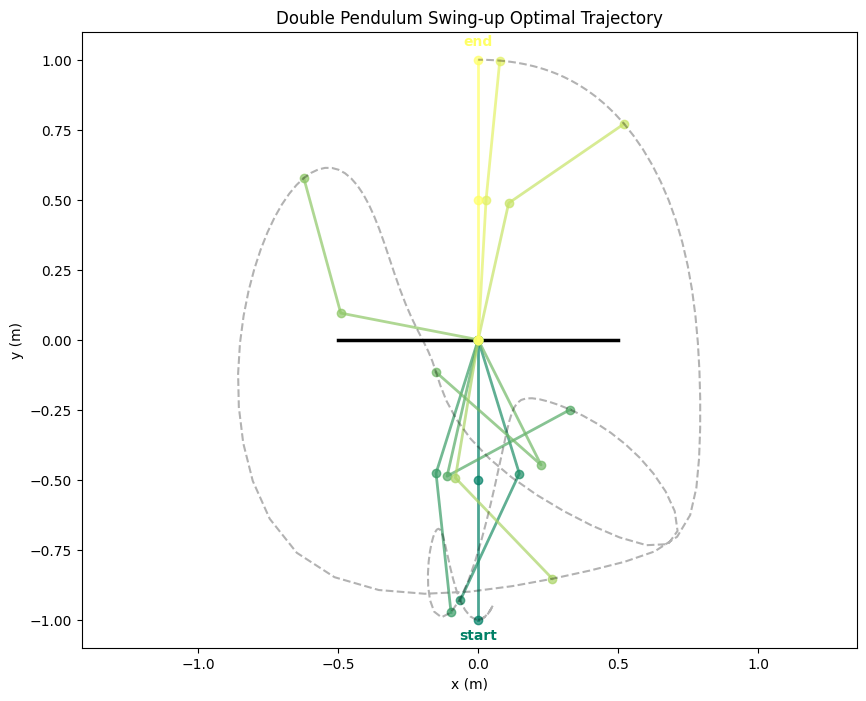

In [42]:
# --- Cell 9 ---
# Trajectory Simulation
optimized_data = results.x.reshape(-1, 6)

q1_bar = optimized_data[:, 0]
q2_bar = optimized_data[:, 1]
q1_dot_bar = optimized_data[:, 2]
q2_dot_bar = optimized_data[:, 3]
u1_bar = optimized_data[:, 4]
u2_bar = optimized_data[:, 5]

# Link 1
x1 = l1 * np.sin(q1)
y1 = -l1 * np.cos(q1)

# Link 2
x2 = x1 + l2 * np.sin(q1 + q2)
y2 = y1 - l2 * np.cos(q1 + q2)

frames = 10
indices = np.linspace(0, len(q1)-1, frames, dtype=int)
colors = plt.cm.summer(np.linspace(0, 1, frames))

plt.figure(figsize=(10, 8))
plt.title('Double Pendulum Swing-up Optimal Trajectory')
plt.axis('equal')

plt.plot([-0.5, 0.5], [0, 0], color='black', lw=2.5) # black base-link
for i, idx in enumerate(indices):
    plt.plot([0, x1[idx], x2[idx]], [0, y1[idx], y2[idx]], color=colors[i], marker='o', alpha=0.7, linewidth=2) # double pendulum
plt.plot(x2, y2, 'k--', alpha=0.3) # trajectory trace
plt.xlabel('x (m)')
plt.ylabel('y (m)')

plt.text(x2[0], y2[0] - 0.07, 'start', color=colors[0], ha='center', fontweight='bold')  # 'start' text
plt.text(x2[-1], y2[-1] + 0.05, 'end', color=colors[-1], ha='center', fontweight='bold') # 'end' text

plt.savefig('optimal-trajectory.png', dpi=300)
plt.show()

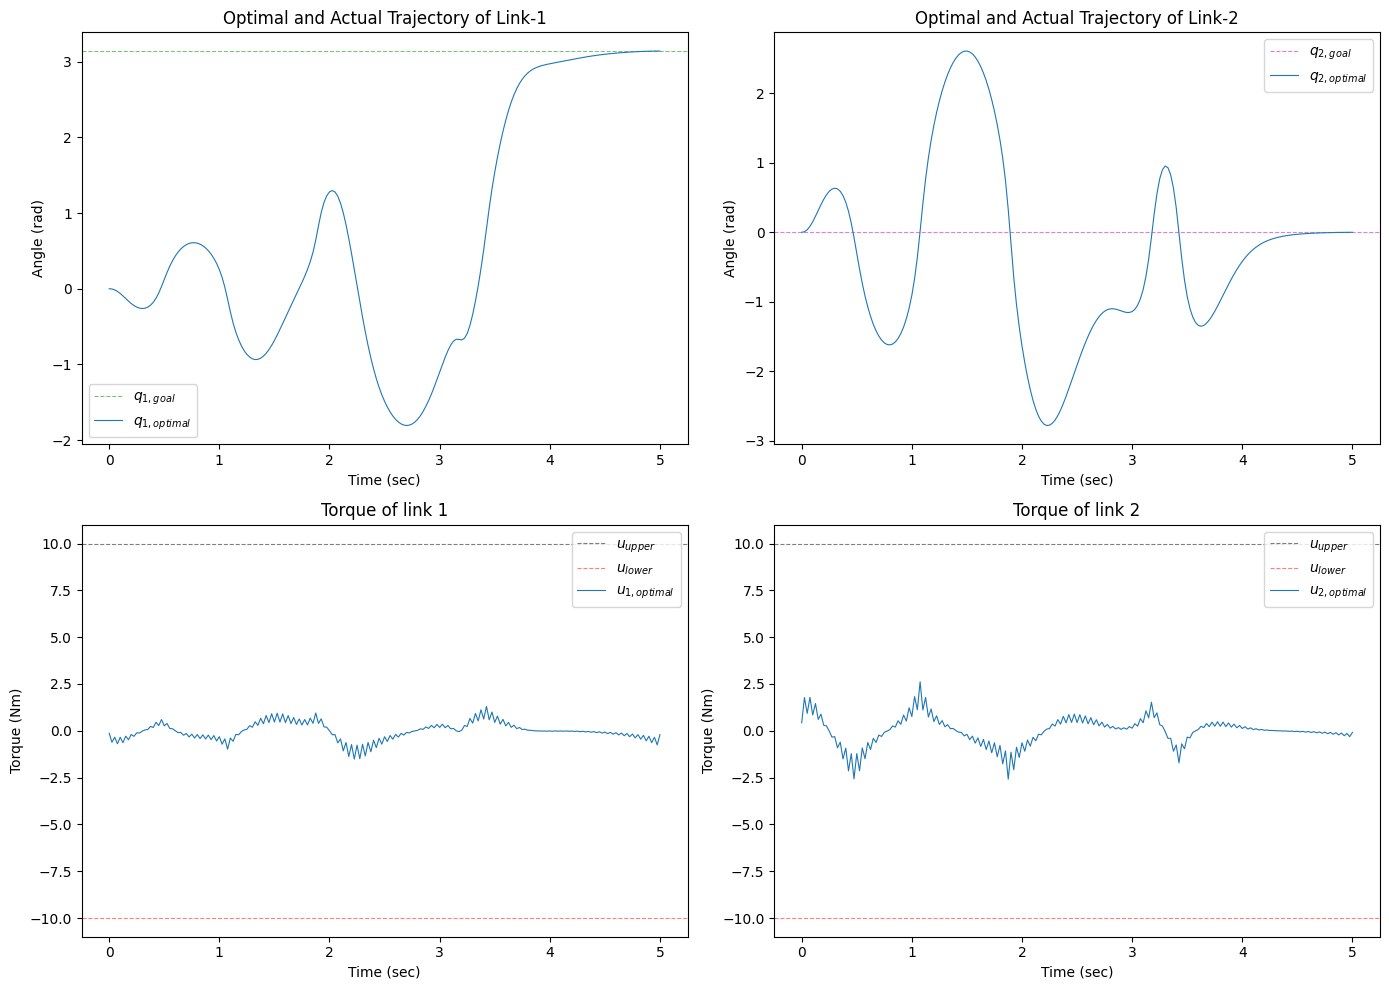

In [45]:
# --- Cell 10 ---
# Diagrams
time = np.linspace(0, tf, 2*S-1)

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Angle of link 1
axs[0,0].set_title('Optimal and Actual Trajectory of Link-1')
axs[0,0].axhline(y=3.1415, color='g', linestyle='--', linewidth=0.8, alpha=0.5, label='$q_{1, goal}$')
axs[0,0].plot(time, q1, linewidth=0.8, label='$q_{1, optimal}$')
axs[0,0].set_xlabel('Time (sec)')
axs[0,0].set_ylabel('Angle (rad)')
axs[0,0].legend()

# Angle of link 2
axs[0,1].set_title('Optimal and Actual Trajectory of Link-2')
axs[0,1].axhline(y=0, color='m', linestyle='--', linewidth=0.8, alpha=0.5, label='$q_{2, goal}$')
axs[0,1].plot(time, q2, linewidth=0.8, label='$q_{2, optimal}$')
axs[0,1].set_xlabel('Time (sec)')
axs[0,1].set_ylabel('Angle (rad)')
axs[0,1].legend()

# Torque of link 1
axs[1,0].set_title('Torque of link 1')
axs[1,0].axhline(y=10, color='k', linestyle='--', linewidth=0.8, alpha=0.5, label='$u_{upper}$')
axs[1,0].axhline(y=-10, color='r', linestyle='--', linewidth=0.8, alpha=0.5, label='$u_{lower}$')
axs[1,0].plot(time, u1, linewidth=0.8, label='$u_{1, optimal}$')
axs[1,0].set_xlabel('Time (sec)')
axs[1,0].set_ylabel('Torque (Nm)')
axs[1,0].legend()

# Torque of link 2
axs[1,1].set_title('Torque of link 2')
axs[1,1].axhline(y=10, color='k', linestyle='--', linewidth=0.8, alpha=0.5, label='$u_{upper}$')
axs[1,1].axhline(y=-10, color='r', linestyle='--', linewidth=0.8, alpha=0.5, label='$u_{lower}$')
axs[1,1].plot(time, u2, linewidth=0.8, label='$u_{2, optimal}$')
axs[1,1].set_xlabel('Time (sec)')
axs[1,1].set_ylabel('Torque (Nm)')
axs[1,1].legend()

plt.savefig('optimal-trajectory-diagrams.png', dpi=300)

plt.tight_layout()
plt.show()

In [46]:
# --- Cell 11 ---
# Save data to .csv file
df = pd.DataFrame({
    'q1': q1,
    'q2': q2,
    'q1_dot': q1_dot,
    'q2_dot': q2_dot,
    'u1': u1,
    'u2': u2
})

df.to_csv('results.csv', index=False)